### Trend Search Methods

In this section, we introduce a new labeling method that does not require defining $h$, profit-taking, or stop-loss barriers. The general idea is to identify trends and maintain positions for as long and far as possible without setting explicit barriers. To achieve this, we first need to define what constitutes a trend.

Given a series of observations $\{x_{t}\}_{t = 1, \ldots, T}$, where $x_t$ represents the price of the security we want to predict, we aim to label each observation $y_t \in \{-1, 0, 1\}$ based on whether $x_t$ is part of a downward trend, sideways movement, or upward trend. One possible method is to calculate the t-value associated with the estimated regression coefficient $\hat{\beta_1}$ from a linear time trend model:

$$
x_{t+l} = \beta_0 + \beta_1 l + \epsilon_{t+l}
$$
$$
\hat{t_{\hat{\beta_1}}} = \frac{\hat{\beta_1}}{\hat{\sigma_{\hat{\beta_1}}}}
$$

Here, $\hat{\sigma_{\hat{\beta_1}}}$ is the standard error of $\hat{\beta_1}$, and $l=0, \ldots, L-1$, with $L$ representing the prediction horizon.

Below is the code to calculate this t-value from the sample determined by $L$:

```python
import pandas as pd
import numpy as np
import statsmodels.api as sm

def calculate_t_values(prices, L):
    # Prepare the DataFrame for regression
    t = np.arange(len(prices))  # Time indices
    model_data = pd.DataFrame({'x': prices, 't': t})
    
    # Initialize lists to hold t-values and labels
    t_values = []
    labels = []

    # Perform regression for the last L periods
    for start in range(len(prices) - L + 1):
        sample = model_data.iloc[start:start + L]
        X = sm.add_constant(sample['t'])  # Add intercept
        y = sample['x']
        
        model = sm.OLS(y, X).fit()
        t_value = model.params[1] / model.bse[1]  # t-value for beta_1
        t_values.append(t_value)

        # Assign labels based on the t-value
        if t_value > 2:  # Example threshold for upward trend
            labels.append(1)
        elif t_value < -2:  # Example threshold for downward trend
            labels.append(-1)
        else:
            labels.append(0)  # Sideways trend

    # Create a DataFrame with results
    result_df = pd.DataFrame({
        't_value': t_values,
        'label': labels
    })
    
    return result_df

# Usage
prices = pd.Series(...)  # Your price data
L = 10  # Example prediction horizon
trend_labels = calculate_t_values(prices, L)

print(trend_labels)
```

In this code, we perform a rolling regression over the last $L$ periods to compute the t-values for the slope of the trend. Based on the t-values, we assign labels indicating the direction of the trend: upward, downward, or sideways. Adjust the threshold values according to your specific criteria for trend identification.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from quant_free.finml.labeling.trend_search import trend_labeling, linear_trend_t_values

In [2]:
import yfinance as yf

start_date = '2000-01-01'
end_date = '2024-04-27'
ticker = 'AAPL'
data = yf.download(
    ticker, 
    start = start_date, 
    end = end_date
)

[*********************100%***********************]  1 of 1 completed


In [4]:
t_vals = linear_trend_t_values(close = data['Adj Close'])

/home/disk1/quant_free/quant_free/finml/labeling/trend_search.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return ols.tvalues[1]


In [6]:
print(f't_vals = {t_vals}')

t_vals = 106.87336722842807


The value of $L$ affects the t-value. To resolve this uncertainty, you can try multiple sets of values for $L$ and select the value that maximizes $|\hat{t_{\beta_1}}|$. This way, you can label $x_t$ based on the most statistically significant trend observed among various possible future outlook periods.

The code below implements this procedure. The inputs are the index of the observation you want to label (`molecule`), the time series of closing prices $\{x_t\}$, and the set of values for $L$ (`span`) that the algorithm will evaluate to find the maximum absolute t-value. The output is a DataFrame indexed by the timestamps of $x_t$, where the `t1` column indicates the timestamp of the furthest observation used to identify the most significant trend, the `tVal` column shows the t-value associated with that trend from the evaluated set of outlook periods, and the `bin` column provides the label ($y_t$).

In [8]:
trend_search = trend_labeling(
    data.index, # datetime Index
    data['Adj Close'], # price series
    span = [1, 20, 1] # time range(start, end, stepsize)
)

KeyboardInterrupt: 

In [10]:
trend_search.head()

,t1,tVal,bin
Date,,,
2000-01-03 00:00:00+00:00,2000-01-28 00:00:00+00:00,-5.39146,-1.0
2000-01-04 00:00:00+00:00,2000-01-31 00:00:00+00:00,-3.914075,-1.0
2000-01-05 00:00:00+00:00,2000-02-01 00:00:00+00:00,3.924722,1.0
2000-01-06 00:00:00+00:00,2000-02-02 00:00:00+00:00,5.065563,1.0
2000-01-07 00:00:00+00:00,2000-02-03 00:00:00+00:00,-6.635231,-1.0


Trending Searching label은 많은 경우 직관적이며, 회귀 문제뿐만 아니라 분류에도 사용될 수 있다. 아래 일련의 결과는 Trend Searching Methods를 사용해 labeling을 하는 법을 보여준다

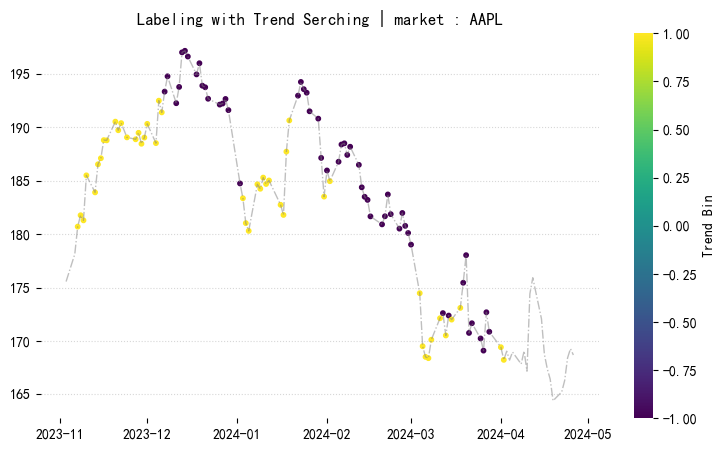

In [11]:
fig, ax = plt.subplots(figsize = (9, 5))
scatter = ax.scatter(
    trend_search.index[-100:], 
    data['Adj Close'].loc[trend_search.index].values[-100:], 
    c = trend_search['bin'].values[-100:], 
    cmap = 'viridis',
    s = 10
)
ax.plot(
    data['Adj Close'][-120:], 
    color = 'gray', 
    alpha = 0.5,
    ls = '-.',
    lw = 1
)

for spine in ax.spines.values():
    spine.set_visible(False)
    
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Labeling with Trend Serching | market : AAPL')

cbar = fig.colorbar(scatter)
cbar.set_label('Trend Bin')
cbar.outline.set_visible(False)

plt.show()

bin값을 추정하는데 사용된 t value는 machine learning 알고리즘 내에서 sample weight로도 사용이 가능하다. 자세한 내용은 chapter 4에서 다루도록 한다

In [12]:
scale = trend_search['tVal'].copy()

scale[scale > 10] = 10
scale[scale < -10] = -10

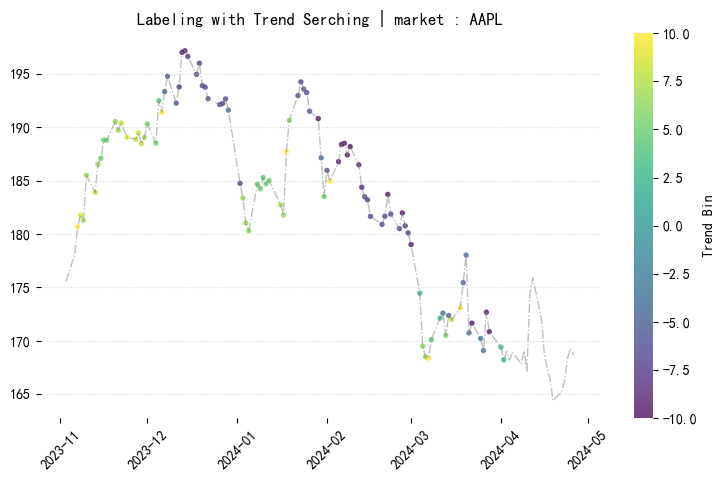

In [13]:
fig, ax = plt.subplots(figsize = (9, 5))
scatter = ax.scatter(
    trend_search.index[-100:], 
    data['Adj Close'].loc[trend_search.index].values[-100:], 
    c = scale[-100:], 
    cmap = 'viridis',
    alpha = 0.75,
    edgecolor = 'none',
    s = 15
)
ax.plot(
    data['Adj Close'][-120:], 
    color = 'gray', 
    alpha = 0.5,
    ls = '-.',
    lw = 1
)
plt.xticks(rotation=45)
for spine in ax.spines.values():
    spine.set_visible(False)
    
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Labeling with Trend Serching | market : AAPL')

cbar = fig.colorbar(scatter)
cbar.set_label('Trend Bin')
cbar.outline.set_visible(False)

plt.show()